# Weighted Rolling Window: mean & std
25 March 2024   
Conda environment: `time-series`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sktime.transformations.series.summarize import WindowSummarizer

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

`Rolling weighted mean`:
$$
\mu_w = \frac{\sum_i w_ix_i}{\sum_i w_i}
$$

`Rolling weighted std`:
$$
\sigma_w = \sqrt{\frac{\sum_i w_i(x_i - \mu_w)^2}{\sum_i w_i}}
$$

In [3]:
### Functions
def weighted_mean(x: np.array, weights: np.array) -> np.array:
    """Weighted mean: define our own weighted mean function to pass to .apply(weighted_mean, args=(weights,))
    Args:
        x (np.array): input data
        weights (np.array): weight array
    Returns:
        np.array: weighted mean
    """
    return (weights * x).sum() / weights.sum()

def weighted_std(x: np.array, weights: np.array) -> np.array:
    """Weighted standard deviation (std): define our own weighted std function to pass to .apply(weighted_std, args=(weights,))
    Args:
        x (np.array): input data
        weights (np.array): weight array
    Returns:
        np.array: weighted std
    """
    mean_w = weighted_mean(x, weights)
    var_w = (weights * (x - mean_w)**2).sum() / weights.sum()
    return np.sqrt(var_w)

## 1) Input data

In [4]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)

# For this demo we will use a subset of the data
data = data.loc["2010":]

data

,demand,temperature
date_time,,
2010-01-01 00:00:00,"8,314.4487",21.5250
2010-01-01 01:00:00,"8,267.1873",22.4000
2010-01-01 02:00:00,"7,394.5284",22.1500
2010-01-01 03:00:00,"6,952.0475",21.8000
2010-01-01 04:00:00,"6,867.1996",20.2500
...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500
2015-02-28 20:00:00,"8,883.2303",22.2000
2015-02-28 21:00:00,"8,320.2605",18.9000


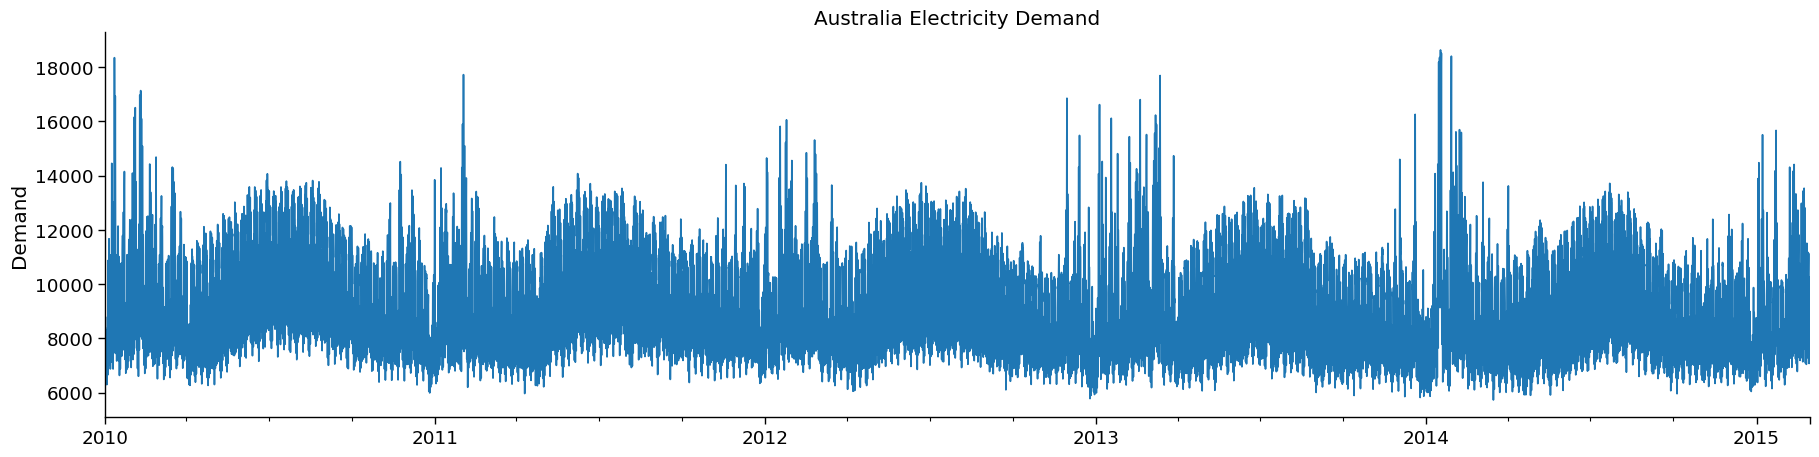

In [5]:
data["demand"].plot()

plt.title("Australia Electricity Demand")
plt.ylabel("Demand")
plt.xlabel("")
plt.show()

## 2) Pandas: Weighted Rolling Window: mean & std
We are going to use: `linear weights`

In [6]:
df = data.copy(deep=True)

# Specify weights: here we shall use linear weights (1 week).
weights = np.arange(1, 24 * 7 + 1)  # [1, 2, ..., 168]

### 2.1) Weighted mean

In [7]:
# Compute weighted mean
result = (
    df["demand"]
    .rolling(window=24 * 7) # Pick window size. Needs to be same as len(weights).
    .apply(weighted_mean, args=(weights,)) # Apply our custom function.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.
    .to_frame() # Convert output from Series to DataFrame.
)
result.columns = ["demand_weighted_window_168_mean"]

# Join with the original df
df = df.join(result, how="left")
df

,demand,temperature,demand_weighted_window_168_mean
date_time,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,NaN
2010-01-01 02:00:00,"7,394.5284",22.1500,NaN
2010-01-01 03:00:00,"6,952.0475",21.8000,NaN
2010-01-01 04:00:00,"6,867.1996",20.2500,NaN
...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"9,466.9131"
2015-02-28 20:00:00,"8,883.2303",22.2000,"9,466.0411"
2015-02-28 21:00:00,"8,320.2605",18.9000,"9,456.9122"


### 2.2) Weighted std

In [8]:
# Compute weighted standard deviation
result = (
    df["demand"]
    .rolling(window=24 * 7)  # Pick window size. Needs to be same as len(weights).
    .apply(weighted_std, args=(weights,))  # Apply our custom function.
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
    .to_frame() # Convert output from Series to DataFrame.
)  
result.columns = ["demand_weighted_window_168_std"]

# Join the result back to the original dataframe.
df = df.join(result, how="left")
df

,demand,temperature,demand_weighted_window_168_mean,demand_weighted_window_168_std
date_time,,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,NaN,NaN
2010-01-01 02:00:00,"7,394.5284",22.1500,NaN,NaN
2010-01-01 03:00:00,"6,952.0475",21.8000,NaN,NaN
2010-01-01 04:00:00,"6,867.1996",20.2500,NaN,NaN
...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"9,466.9131","1,343.5537"
2015-02-28 20:00:00,"8,883.2303",22.2000,"9,466.0411","1,333.0214"
2015-02-28 21:00:00,"8,320.2605",18.9000,"9,456.9122","1,324.0231"


In [9]:
# Let's also compute the unweighted rolling mean for comparison
result = (
    df["demand"]
    .rolling(window=24 * 7)  # Pick window size.
    .agg(["mean"])  # Pass our own functions.
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
)
result.columns = ["demand_window_168_mean"]
df = df.join(result, how="left")
df

,demand,temperature,demand_weighted_window_168_mean,demand_weighted_window_168_std,demand_window_168_mean
date_time,,,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN,NaN,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,NaN,NaN,NaN
2010-01-01 02:00:00,"7,394.5284",22.1500,NaN,NaN,NaN
2010-01-01 03:00:00,"6,952.0475",21.8000,NaN,NaN,NaN
2010-01-01 04:00:00,"6,867.1996",20.2500,NaN,NaN,NaN
...,...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"9,466.9131","1,343.5537","9,670.4635"
2015-02-28 20:00:00,"8,883.2303",22.2000,"9,466.0411","1,333.0214","9,654.6168"
2015-02-28 21:00:00,"8,320.2605",18.9000,"9,456.9122","1,324.0231","9,638.0186"


### 2.3) Plot

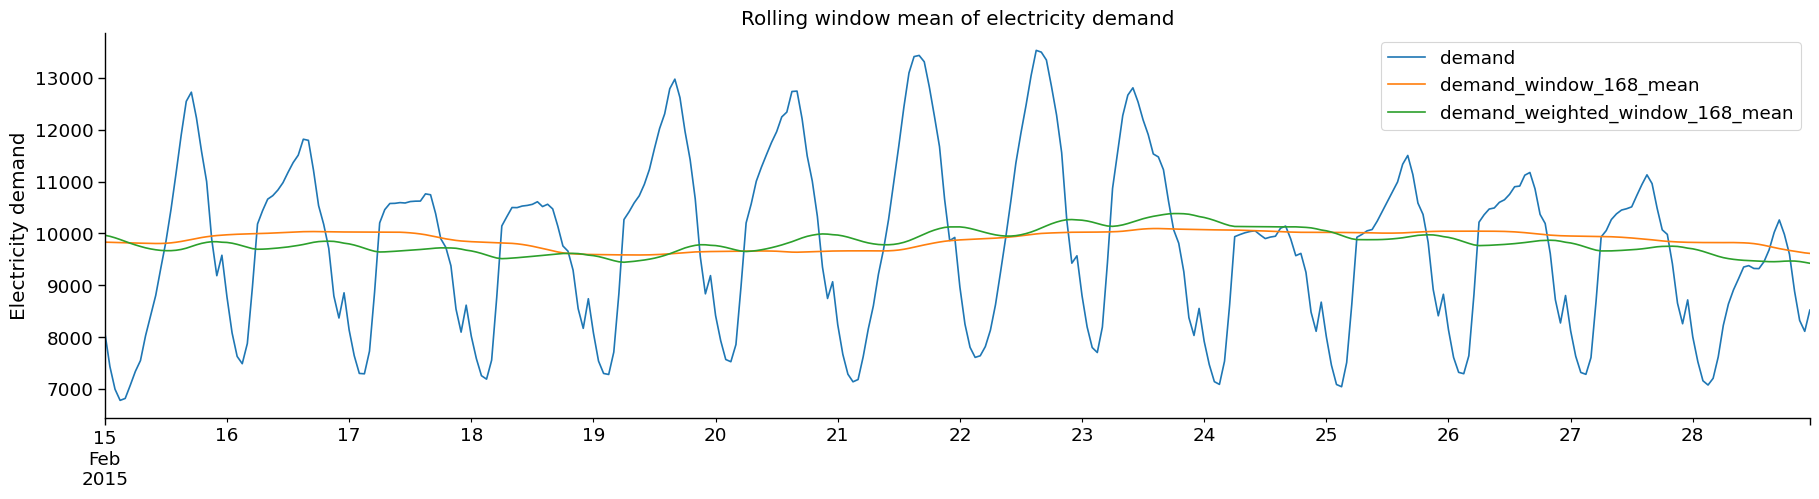

In [10]:
cols = ["demand", "demand_window_168_mean", "demand_weighted_window_168_mean"]

ax = (
    df.iloc[-24 * 7 * 2 :] # Let's look at the last 2 weeks of data
    .loc[:, cols] # Filter to columns of interest
    .plot()
    )

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("")

plt.show()

### 2.4) Agg intead of apply

In [11]:
def weighted_mean(x: np.array) -> np.array:
    weights = np.arange(1, 24 * 7 + 1) # [1, 2, ..., 168]
    return (weights * x).sum() / weights.sum()

result = (
    df["demand"]
    .rolling(window=24 * 7)  # Pick window size. Needs to be same as len(weights).
    .agg(["mean", "std", weighted_mean])  # Can include custom functions
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
)
result

,mean,std,weighted_mean
date_time,,,
2010-01-01 01:00:00,NaN,NaN,NaN
2010-01-01 02:00:00,NaN,NaN,NaN
2010-01-01 03:00:00,NaN,NaN,NaN
2010-01-01 04:00:00,NaN,NaN,NaN
2010-01-01 05:00:00,NaN,NaN,NaN
...,...,...,...
2015-02-28 20:00:00,"9,654.6168","1,526.8382","9,466.0411"
2015-02-28 21:00:00,"9,638.0186","1,519.9200","9,456.9122"
2015-02-28 22:00:00,"9,624.1083","1,521.2299","9,441.3174"


## 3) sktime: Weighted Rolling Window: mean & std
We are going to use: `linear weights`

In [12]:
def weighted_mean(x: np.array) -> np.array:
    weights = np.arange(1, 24 * 7 + 1) # [1, 2, ..., 168]
    return (weights * x).sum() / weights.sum()

df = data.copy(deep=True)

In [13]:
transformer = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3], # Lag features.
        "mean": [[1, 12], [1, 3]], # [[lag, window size]]
        "std": [[1, 12], [1, 3]],
        weighted_mean: [[1, 24 * 7]], # Can pass custom functions.
    },
    target_cols=["demand"],
)

result = transformer.fit_transform(df)
df = result.join(df["demand"], how="left")
df

,demand_lag_1,demand_lag_2,demand_lag_3,demand_mean_1_12,demand_mean_1_3,demand_std_1_12,demand_std_1_3,demand_weighted_mean_1_168,temperature,demand
date_time,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5250,"8,314.4487"
2010-01-01 01:00:00,"8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.4000,"8,267.1873"
2010-01-01 02:00:00,"8,267.1873","8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,22.1500,"7,394.5284"
2010-01-01 03:00:00,"7,394.5284","8,267.1873","8,314.4487",NaN,"7,992.0548",NaN,518.0123,NaN,21.8000,"6,952.0475"
2010-01-01 04:00:00,"6,952.0475","7,394.5284","8,267.1873",NaN,"7,537.9211",NaN,669.1930,NaN,20.2500,"6,867.1996"
...,...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,"9,979.9099","10,258.5854","10,019.9216","9,453.2962","10,086.1390",468.9886,150.6770,"9,466.9131",28.3500,"9,596.7771"
2015-02-28 20:00:00,"9,596.7771","9,979.9099","10,258.5854","9,533.3359","9,945.0908",392.6233,332.2753,"9,466.0411",22.2000,"8,883.2303"
2015-02-28 21:00:00,"8,883.2303","9,596.7771","9,979.9099","9,531.0880","9,486.6391",396.5726,556.5737,"9,456.9122",18.9000,"8,320.2605"
